# Creating the Bathymetry

In this notebook, we will create two grids for my model: Coarse (1-degree) and Medium (0.5-degree)

In [3]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

I stored the bathymetry as `global_bathymetry.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [4]:
# read in the bathymetry grid
file_path = 'global_bathymetry.nc'
ds = nc4.Dataset(file_path)

Globe_bathy_lon = ds.variables['longitude'][:]
Globe_bathy_lat = ds.variables['latitude'][:]
Globe_bathy = ds.variables['Depth'][:]
Globe_bathy = Globe_bathy*-1
ds.close()

# create a meshgrid of the lon and lat
Globe_Lon, Globe_Lat = np.meshgrid(Globe_bathy_lon, Globe_bathy_lat)

In [13]:
# COARSE GRID PARAMS
delX_coarse, delY_coarse = 1, 1
n_cols_coarse, n_rows_coarse = 360, 180

# MED GRID PARAMS
delX_medium, delY_medium = 1/2, 1/2
n_cols_medium, n_rows_medium = 720, 360

xgOrigin, ygOrigin = -180, -90

def get_xc_yc(delX, delY, n_cols, n_rows, xgOrigin, ygOrigin):
    xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
    yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
    XC, YC = np.meshgrid(xc, yc)

    print('Double check shape:', np.shape(xc)[0], 'x' , np.shape(yc)[0])
    print('Number of grid cells:', n_cols*n_rows)
    return xc, yc, XC, YC

print('COARSE GRID')
xc_coarse, yc_coarse, XC_coarse, YC_coarse = get_xc_yc(delX_coarse, delY_coarse, n_cols_coarse, n_rows_coarse, xgOrigin, ygOrigin)

print('\nMED GRID')
xc_medium, yc_medium, XC_medium, YC_medium = get_xc_yc(delX_medium, delY_medium, n_cols_medium, n_rows_medium, xgOrigin, ygOrigin)

COARSE GRID
Double check shape: 360 x 180
Number of grid cells: 64800

MED GRID
Double check shape: 720 x 360
Number of grid cells: 259200


In [14]:
# interpolate the gebco data onto the model grid
Model_bathy_coarse = griddata(np.column_stack([Globe_Lon.ravel(),Globe_Lat.ravel()]), Globe_bathy.ravel(), (XC_coarse, YC_coarse), method='nearest')
Model_bathy_medium = griddata(np.column_stack([Globe_Lon.ravel(),Globe_Lat.ravel()]), Globe_bathy.ravel(), (XC_medium, YC_medium), method='nearest')

# set points on land to 0
Model_bathy_coarse[Model_bathy_coarse>0] = 0
Model_bathy_medium[Model_bathy_medium>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

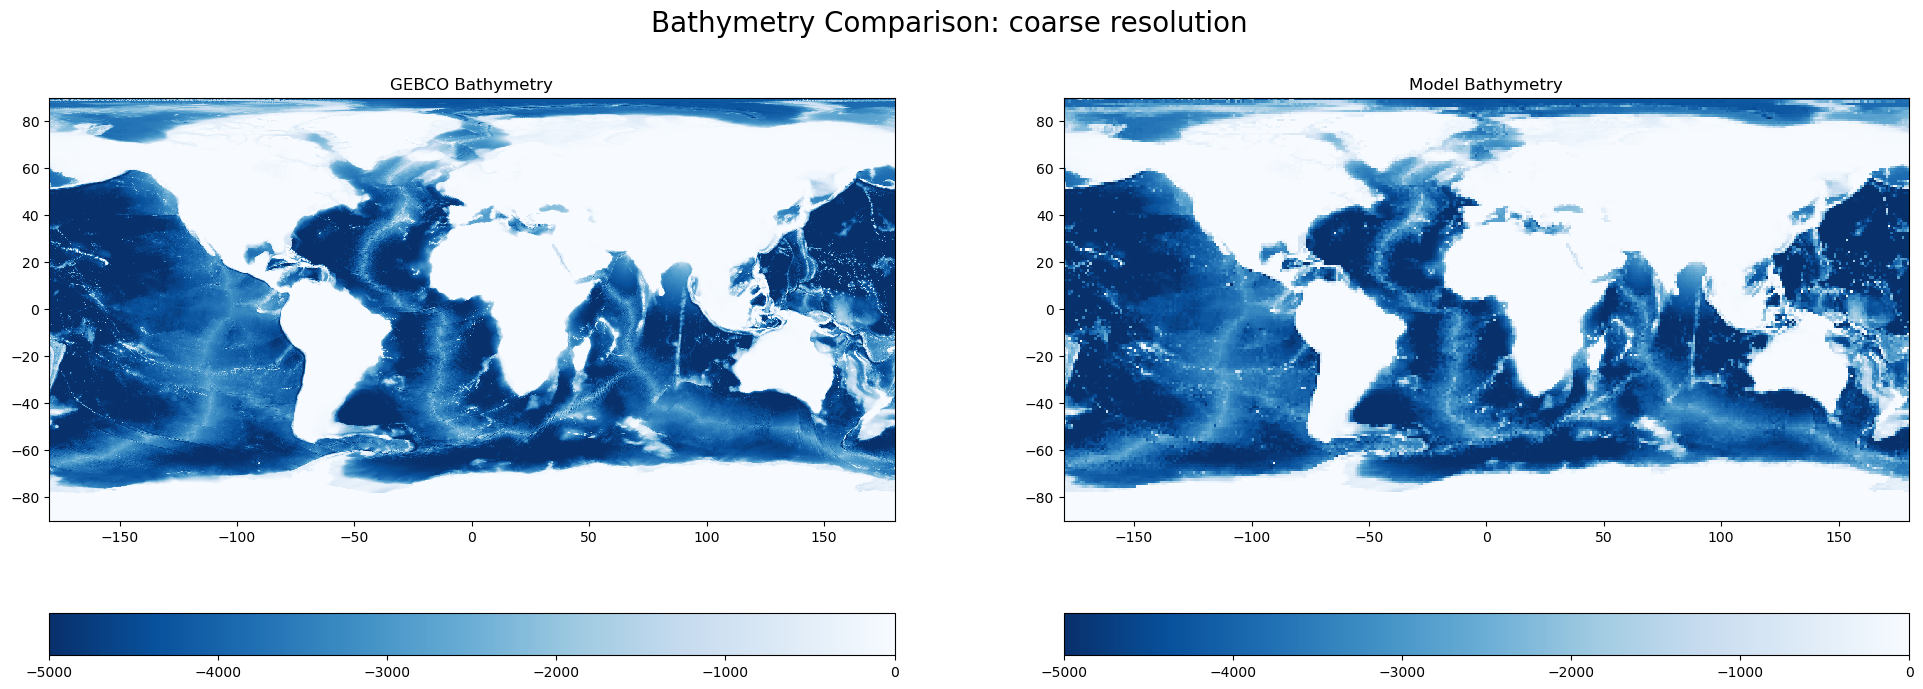

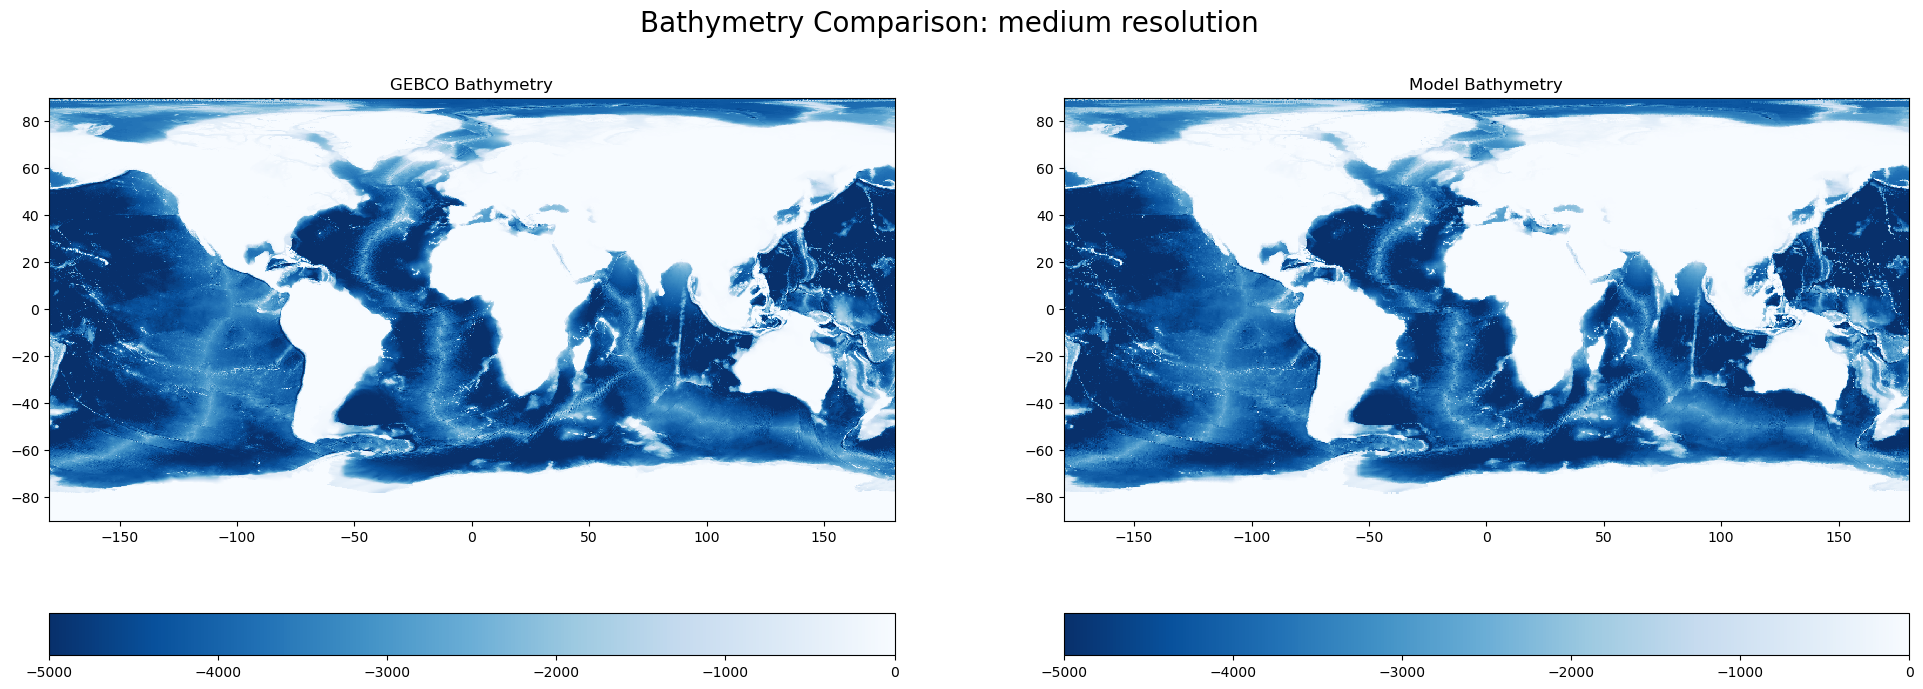

In [15]:
def vis_bathy(XC, YC, Model_bathy, res = 'coarse'):
    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    C = plt.pcolormesh(Globe_Lon, Globe_Lat, Globe_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation = 'horizontal')
    plt.title('GEBCO Bathymetry')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.subplot(1,2,2)
    C = plt.pcolormesh(XC, YC , Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation = 'horizontal')
    plt.title('Model Bathymetry')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle('Bathymetry Comparison: ' + res + ' resolution', fontsize=20)

    plt.show()
    plt.close()

vis_bathy(XC_coarse, YC_coarse, Model_bathy_coarse, res = 'coarse')
vis_bathy(XC_medium, YC_medium, Model_bathy_medium, res = 'medium')

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

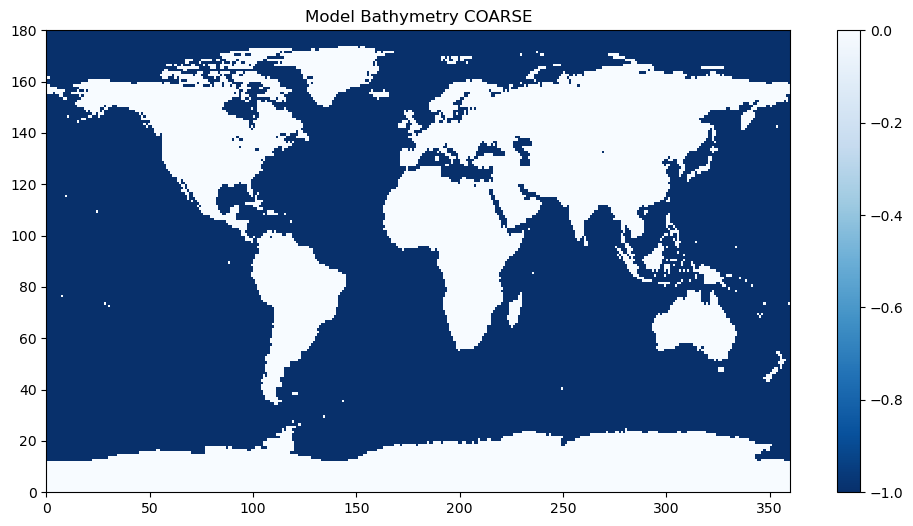

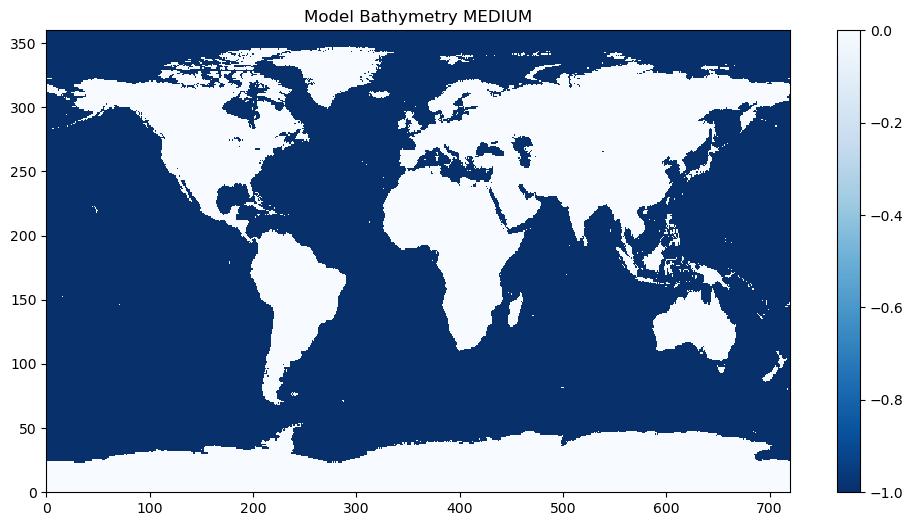

In [ ]:
plt.figure(figsize=(12,6))
C = plt.pcolormesh(Model_bathy_coarse, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry COARSE')
plt.show()
plt.close()


plt.figure(figsize=(12,6))
C = plt.pcolormesh(Model_bathy_medium, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry MEDIUM')
plt.show()
plt.close()

As we can see, there are several isolated water regions, such as the Great Lakes. In addition, there is extreme detail in some areas. Before proceeding with the model, these regions need to be addressed.

Fortunately, Mike has written a tool to fill in these unconnected regions (Thanks Mike!). You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [17]:
import os
import sys
from scipy.ndimage import binary_opening, binary_closing
sys.path.append(os.path.abspath(os.path.join('../../../downscale_ecco')))
from eccoseas.downscale import bathymetry as edb

Make a binary grid that we will use to mask the model grid

Now, with the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [18]:
def fill_bin_grid(Model_bathy, row, col):
    binary_grid = np.copy(Model_bathy)
    binary_grid[binary_grid<0] = -1
    binary_grid[binary_grid>=0] = 0
    model_binary_grid = edb.fill_unconnected_model_regions(binary_grid, central_wet_row=row, central_wet_col=col)
    return model_binary_grid

model_binary_grid_coarse = fill_bin_grid(Model_bathy_coarse, row=150, col=150)
model_binary_grid_medium = fill_bin_grid(Model_bathy_medium, row=300, col=300)


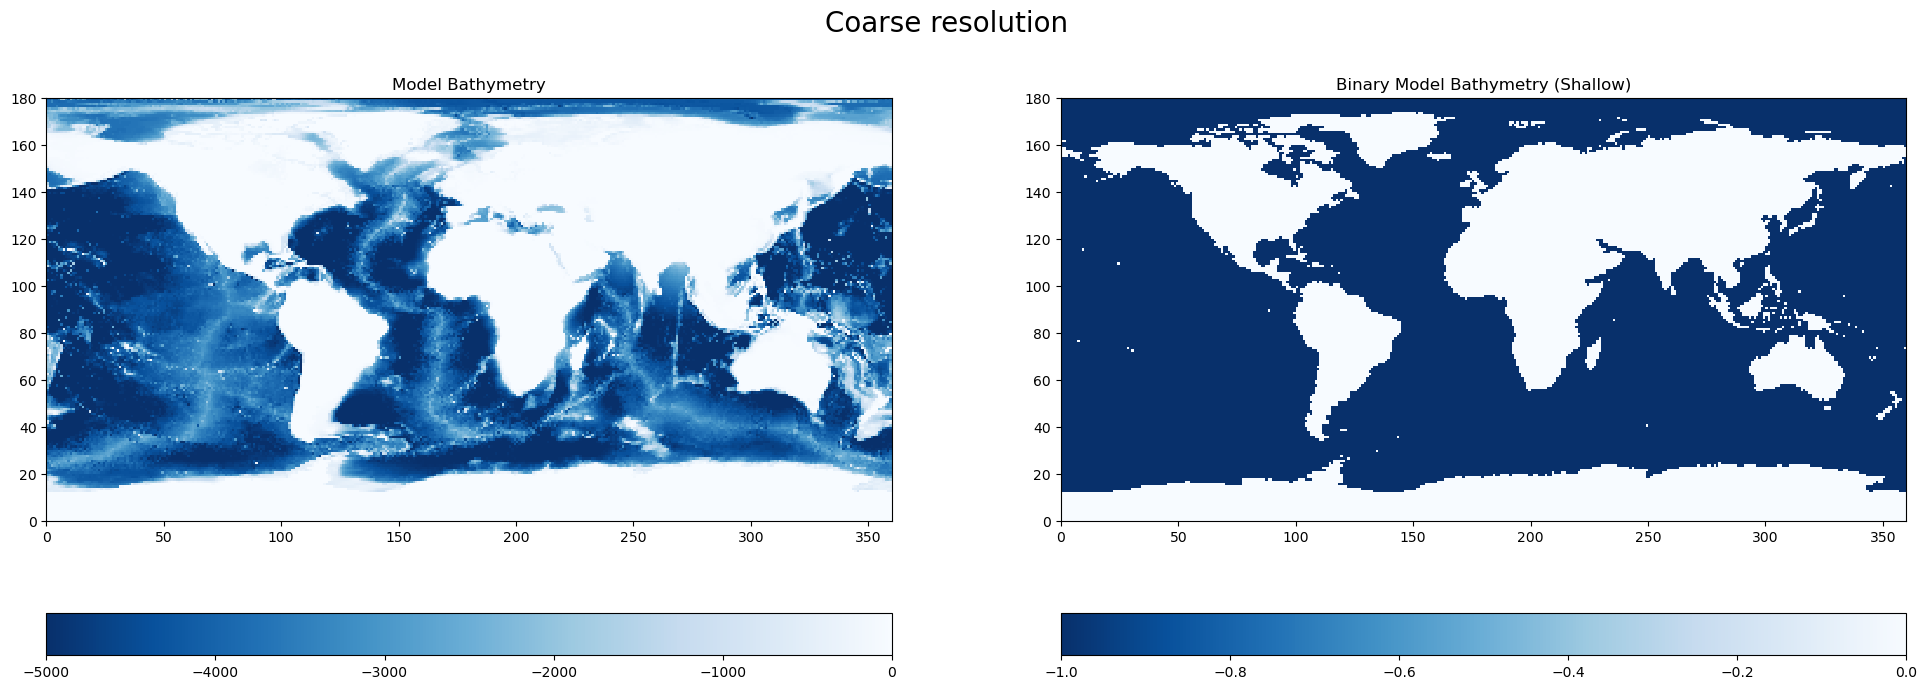

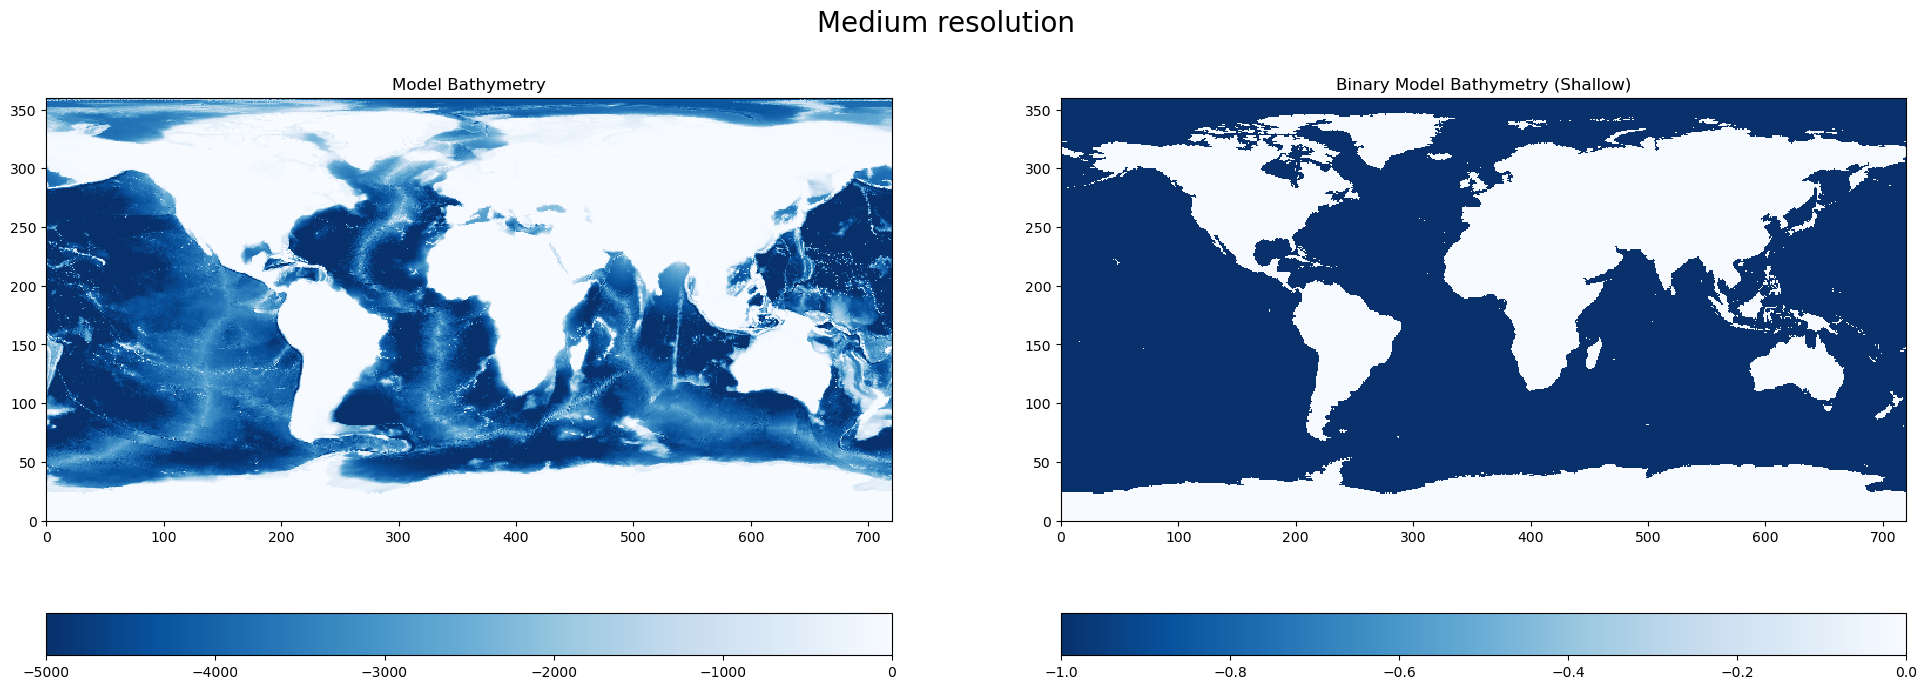

In [23]:
def vis_bathy_binary(Model_bathy, binary_grid, res = 'coarse'):
    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    C = plt.pcolormesh(Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation='horizontal')
    plt.title('Model Bathymetry')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.subplot(1,2,2)
    C = plt.pcolormesh(binary_grid, vmin=-1, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation='horizontal')
    plt.title('Binary Model Bathymetry (Shallow)')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle(res + ' resolution', fontsize=20)

    plt.show()
    plt.close()

vis_bathy_binary(Model_bathy_coarse, model_binary_grid_coarse, res = 'Coarse')
vis_bathy_binary(Model_bathy_medium, model_binary_grid_medium, res = 'Medium')

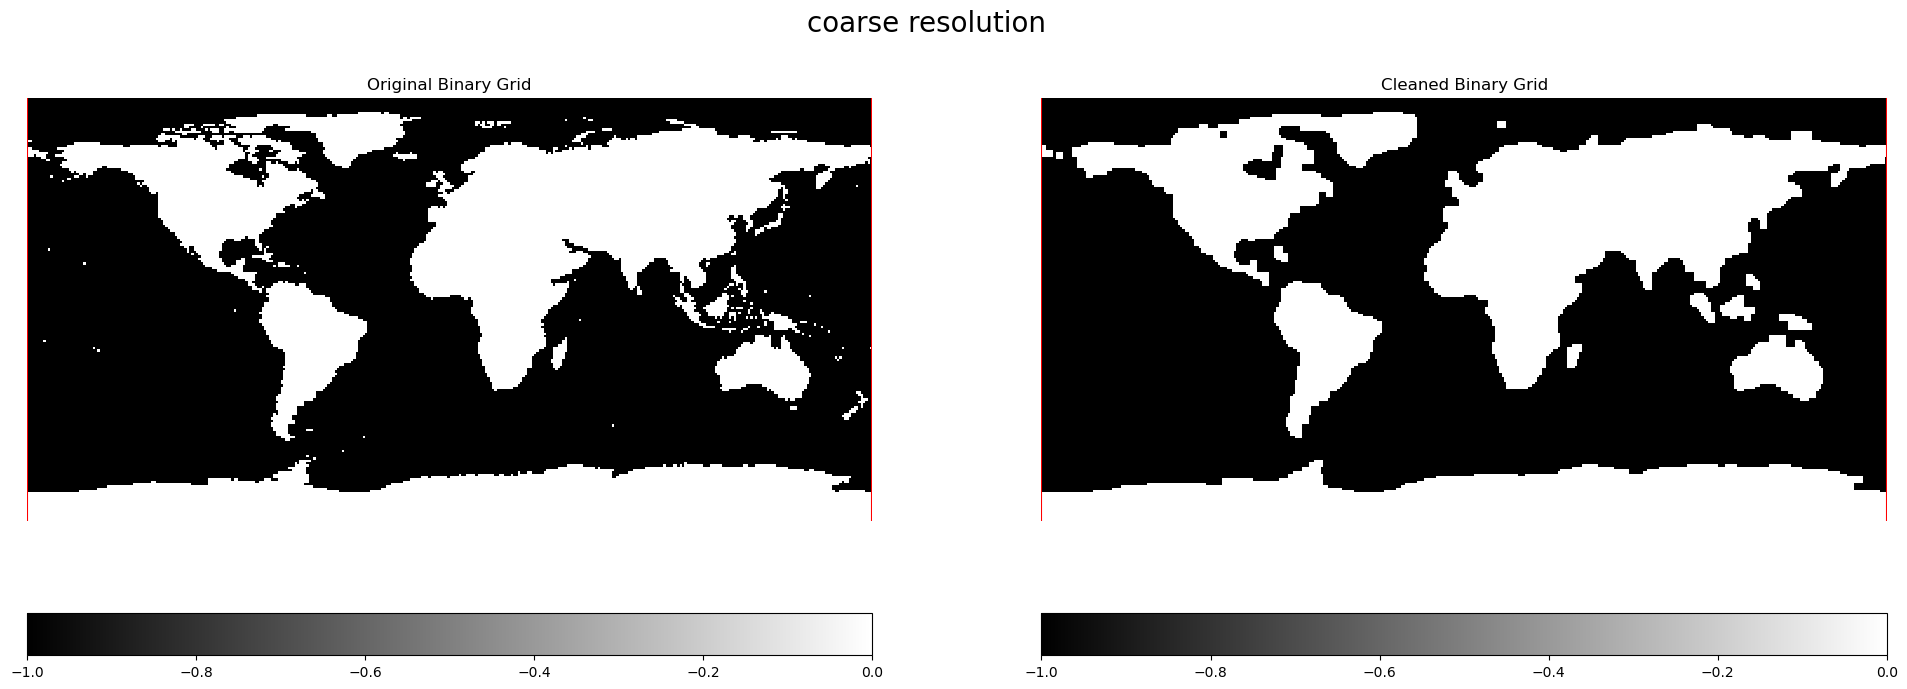

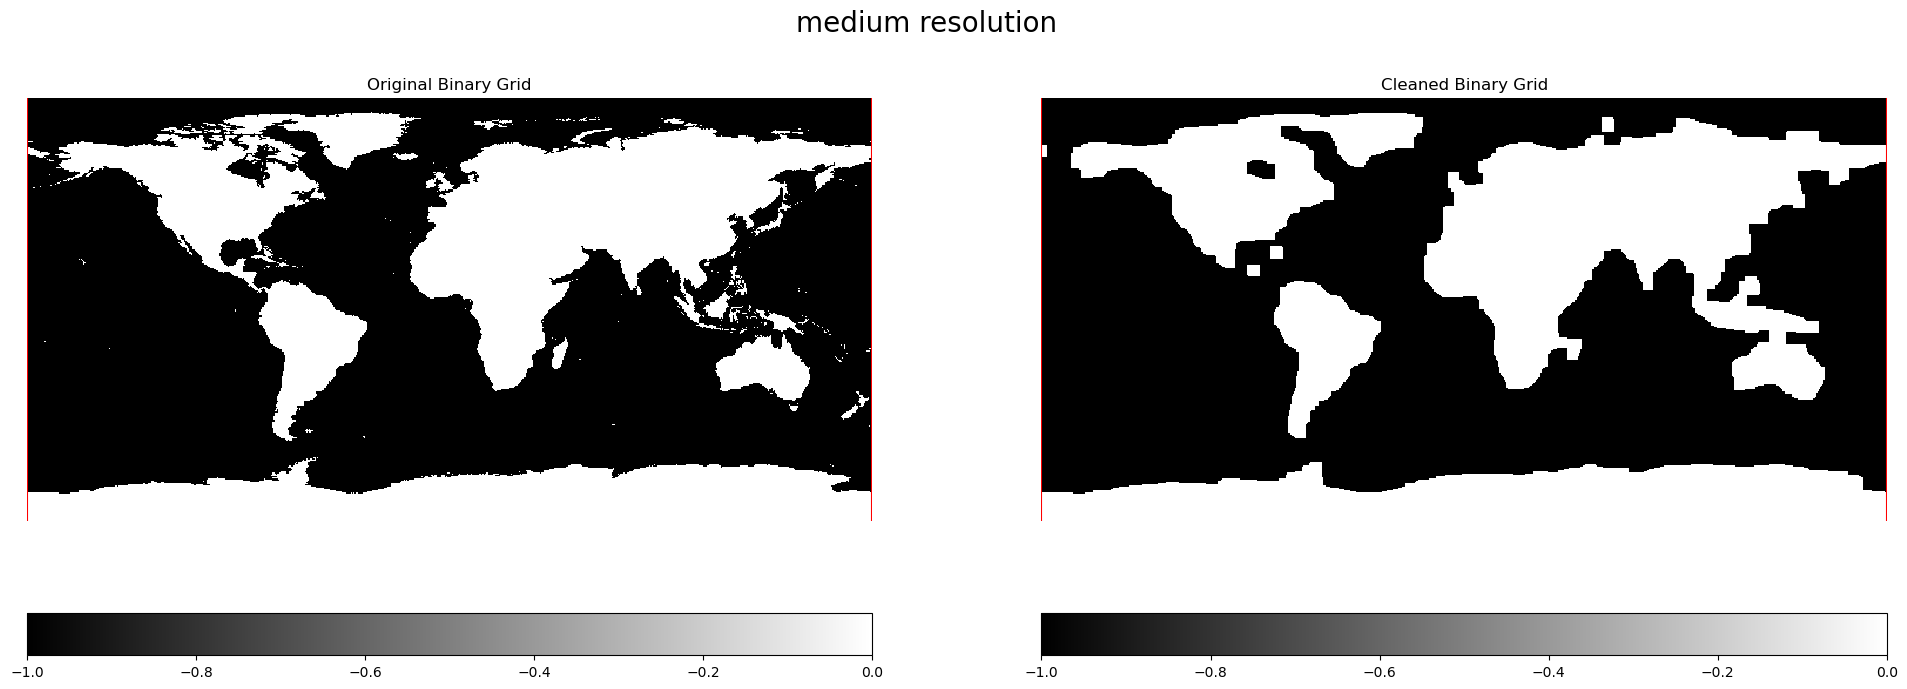

In [28]:
def bin_open_close(model_binary_grid, n_cols, n_rows, res):

    model_binary_grid_bin = np.copy(model_binary_grid)
    model_binary_grid_bin = model_binary_grid_bin * -1

    if res == 'coarse':
        bubble_size = 3
    elif res == 'medium':
        bubble_size = 9
    structure = np.ones((bubble_size,bubble_size))

    # repeat grid for periodic boundaries (because this function eats away at the edges)
    repeated_grid = np.tile(model_binary_grid_bin, (3,3)) 
    opened_grid = binary_opening(repeated_grid, structure=structure)    # close holes of 1s
    cleaned_grid = binary_closing(opened_grid, structure=structure)     # close holes of 0s

    cleaned_grid = cleaned_grid*-1

    cleaned_grid[(n_cols)-5:(n_cols), :] = -1

    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    C = axs[0].pcolormesh(model_binary_grid_bin*-1, cmap='gray')
    axs[0].set_title('Original Binary Grid')
    axs[0].axis('off')
    axs[0].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
    axs[0].axvline(x=0, color='red')
    axs[0].axvline(x=n_cols, color='red')
    plt.gca().set_aspect('equal', adjustable='box')

    # cleaned_grid = cleaned_grid[n_rows:(n_rows*2), n_cols:(n_cols*2)]

    C = axs[1].pcolormesh(cleaned_grid[n_rows:(n_rows*2), n_cols:(n_cols*2)], cmap='gray')
    axs[1].set_title('Cleaned Binary Grid')
    axs[1].axis('off')
    axs[1].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
    axs[1].axvline(x=0, color='red')
    axs[1].axvline(x=n_cols, color='red')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle(res + ' resolution', fontsize=20)

    plt.show()
    plt.close()

    return cleaned_grid

cleaned_grid_coarse = bin_open_close(model_binary_grid_coarse, n_cols_coarse, n_rows_coarse, 'coarse')
cleaned_grid_medium = bin_open_close(model_binary_grid_medium, n_cols_medium, n_rows_medium, 'medium')

Pretty good, but the borders could be smoother. Lets take advantage of the entropy of morpological operations. That is, we will dialate and erode the grid repeatedlly in order to smooth the borders. 

https://en.wikipedia.org/wiki/Mathematical_morphology

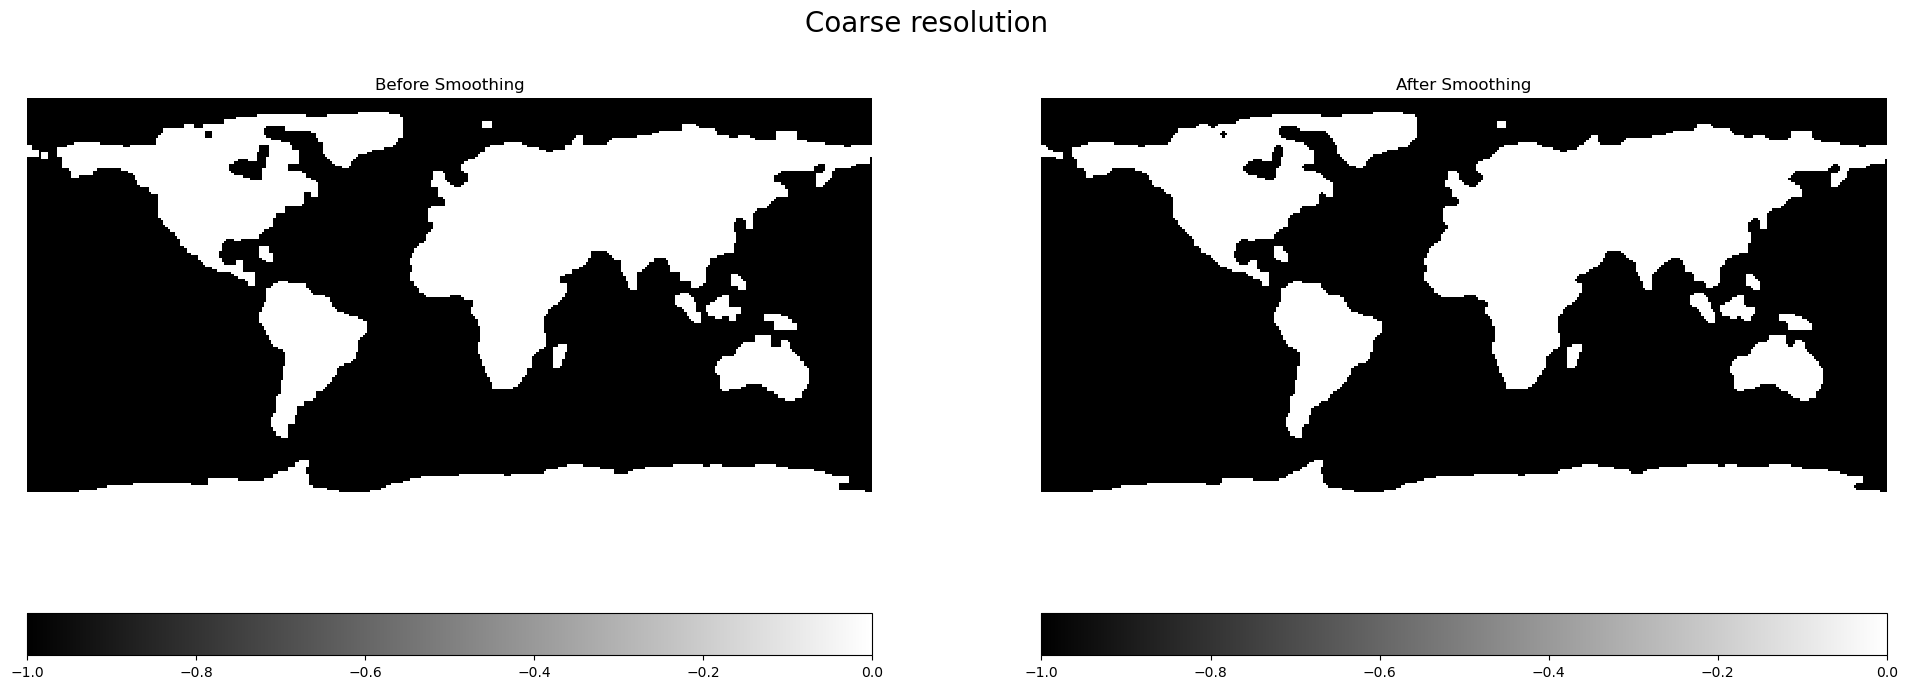

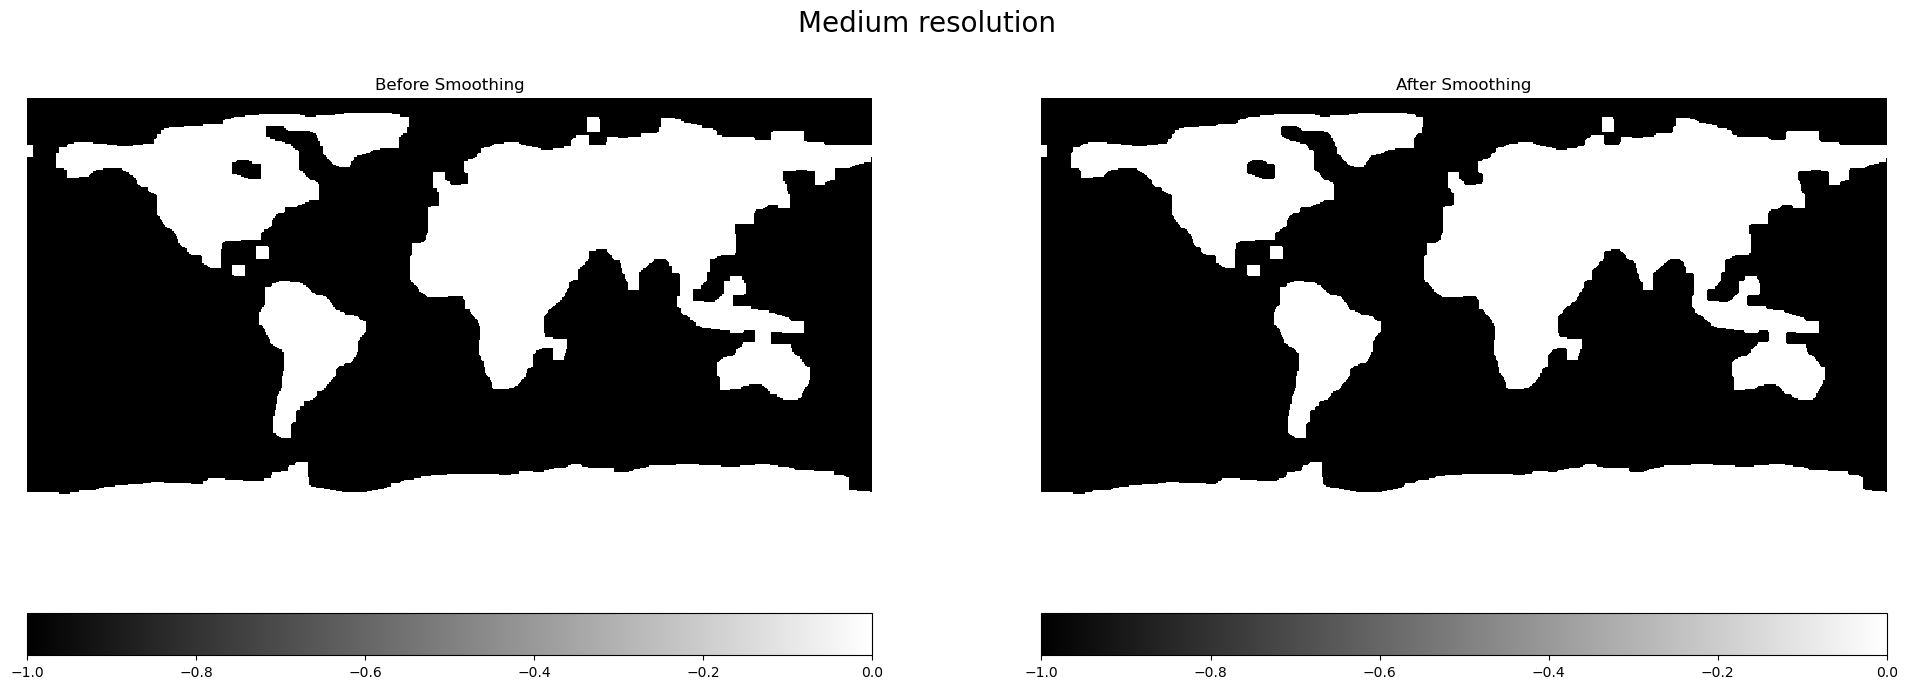

In [30]:
from scipy.ndimage import binary_dilation, binary_erosion



def morphological_smoothing(cleaned_grid, n_rows, n_cols, res):
    def smooth_binary_grid(grid, iterations):
        # erode and dialate repeatedly to smooth the borders
        # like mixing dough 
        smoothed_grid = grid.copy()
        for _ in range(iterations):
            smoothed_grid = binary_erosion(smoothed_grid)
            smoothed_grid = binary_dilation(smoothed_grid)
        return smoothed_grid
    

    smoothed_grid = smooth_binary_grid(cleaned_grid*-1, iterations=1000)
    smoothed_grid = smoothed_grid*-1


    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    C = axs[0].pcolormesh(cleaned_grid[n_rows:(n_rows*2), n_cols:(n_cols*2)], cmap='gray')
    axs[0].set_title('Before Smoothing')
    axs[0].axis('off')
    axs[0].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
    plt.gca().set_aspect('equal', adjustable='box')

    C = axs[1].pcolormesh(smoothed_grid[n_rows:(n_rows*2), n_cols:(n_cols*2)], cmap='gray')
    axs[1].set_title('After Smoothing')
    axs[1].axis('off')
    axs[1].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle(res + ' resolution', fontsize=20)

    plt.show()

    return smoothed_grid

smoothed_grid_coarse = morphological_smoothing(cleaned_grid_coarse, n_rows_coarse, n_cols_coarse, 'Coarse')
smoothed_grid_medium = morphological_smoothing(cleaned_grid_medium, n_rows_medium, n_cols_medium, 'Medium')

In [31]:
# Crop out the original grid

def crop_grid(grid, n_rows, n_cols):
    return grid[n_rows:(n_rows*2), n_cols:(n_cols*2)]
    # smoothed_grid = smoothed_grid[n_rows:(n_rows*2), n_cols:(n_cols*2)]

def clean_grid(Model_bathy, smoothed_grid):
    Model_bathy_cleaned = (np.copy(Model_bathy)-1) * (smoothed_grid*-1)
    # Fill some more. For fun. For Frodo. 
    Model_bathy_cleaned = edb.fill_unconnected_model_regions(Model_bathy_cleaned, central_wet_row=30, central_wet_col=30)
    return Model_bathy_cleaned

clean_grid_coarse = clean_grid(Model_bathy_coarse, crop_grid(smoothed_grid_coarse, n_rows_coarse, n_cols_coarse))
clean_grid_medium = clean_grid(Model_bathy_medium, crop_grid(smoothed_grid_medium, n_rows_medium, n_cols_medium))

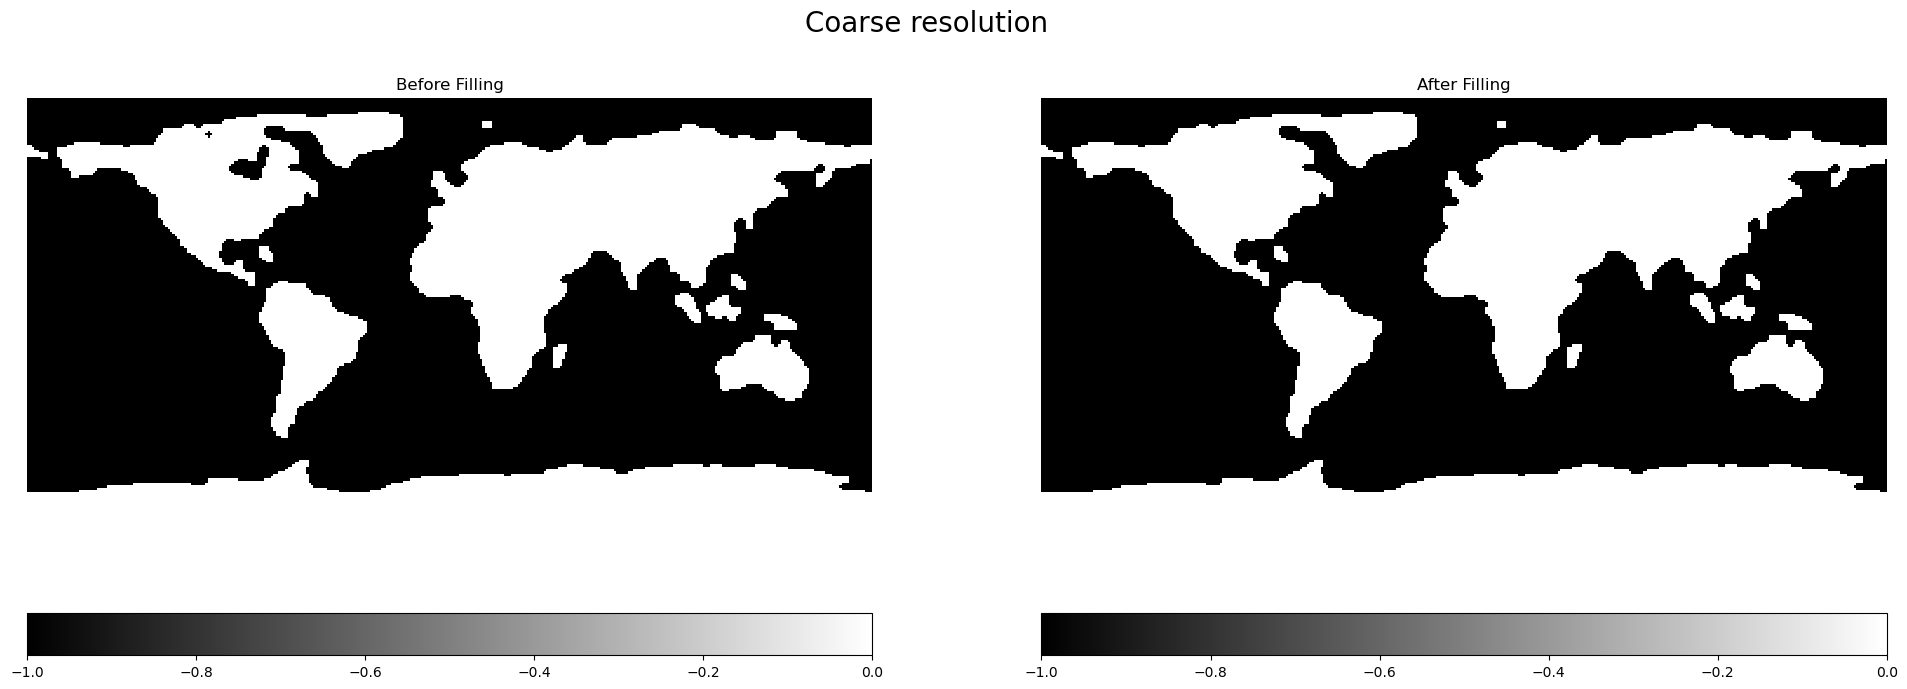

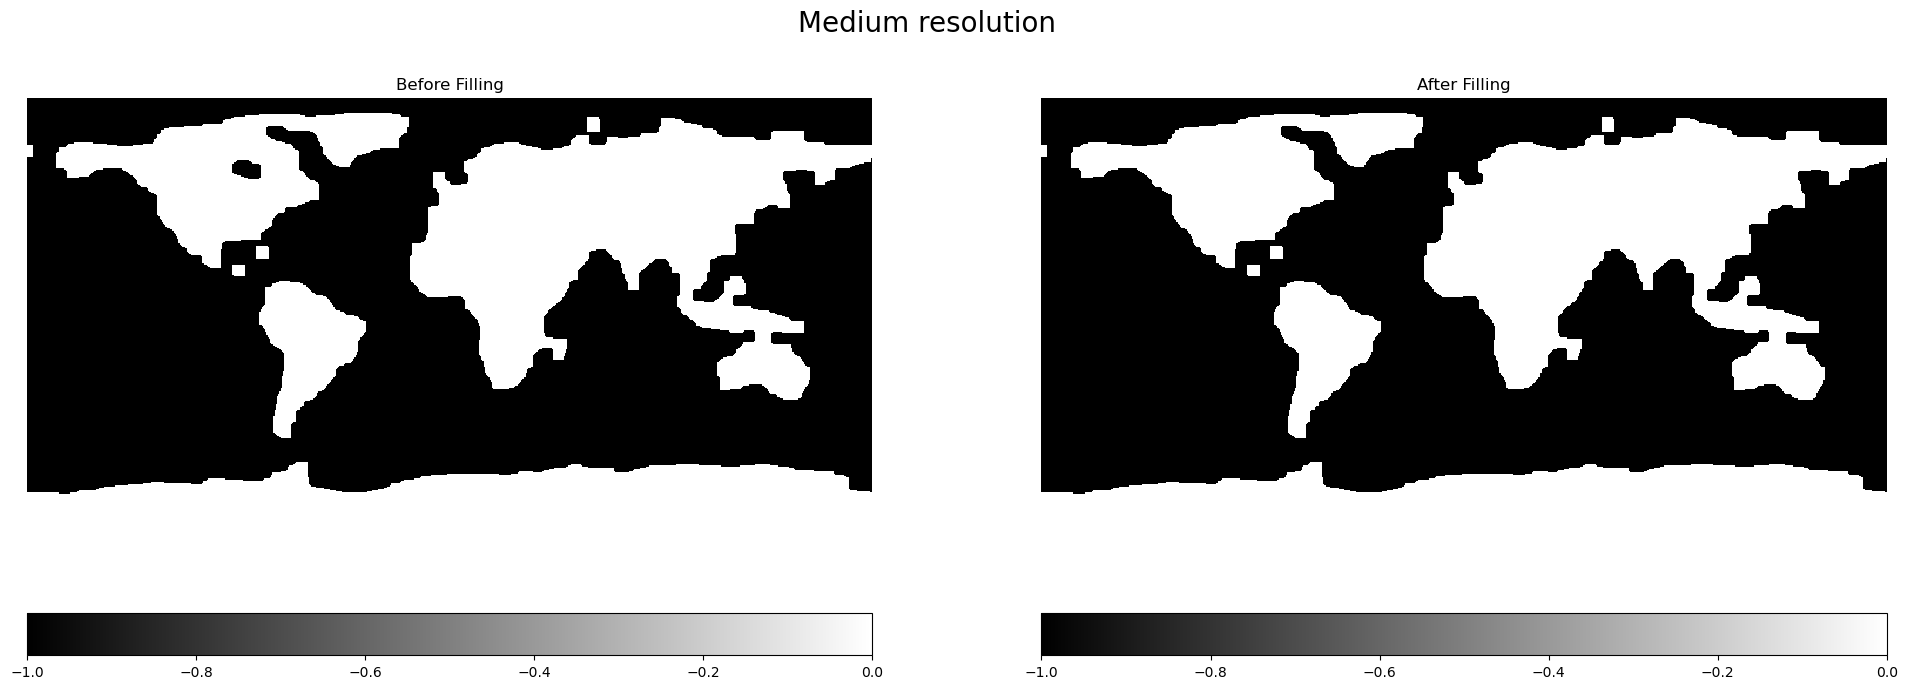

In [32]:
def vis_bin_grid(smoothed_grid, Model_bathy_cleaned, res):

    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    C = axs[0].pcolormesh(smoothed_grid, cmap='gray')
    axs[0].set_title('Before Filling')
    axs[0].axis('off')
    axs[0].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
    plt.gca().set_aspect('equal', adjustable='box')

    C = axs[1].pcolormesh(Model_bathy_cleaned, cmap='gray', vmin=-1, vmax=0)
    axs[1].set_title('After Filling')
    axs[1].axis('off')
    axs[1].set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.suptitle(res + ' resolution', fontsize=20)

    plt.show()

vis_bin_grid(crop_grid(smoothed_grid_coarse, n_rows_coarse, n_cols_coarse), clean_grid_coarse, 'Coarse')
vis_bin_grid(crop_grid(smoothed_grid_medium, n_rows_medium, n_cols_medium), clean_grid_medium, 'Medium')

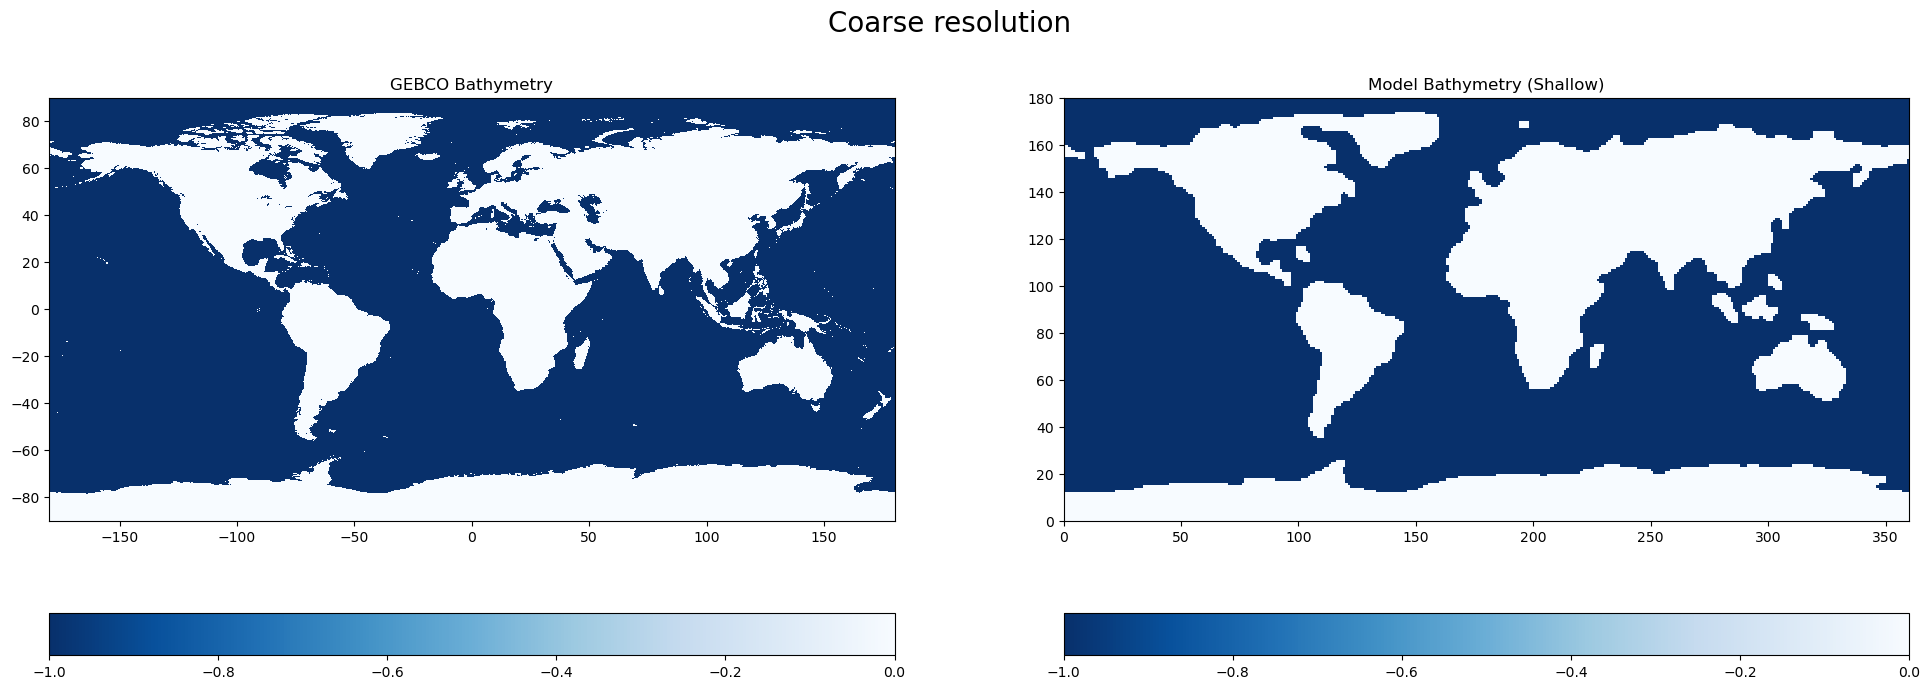

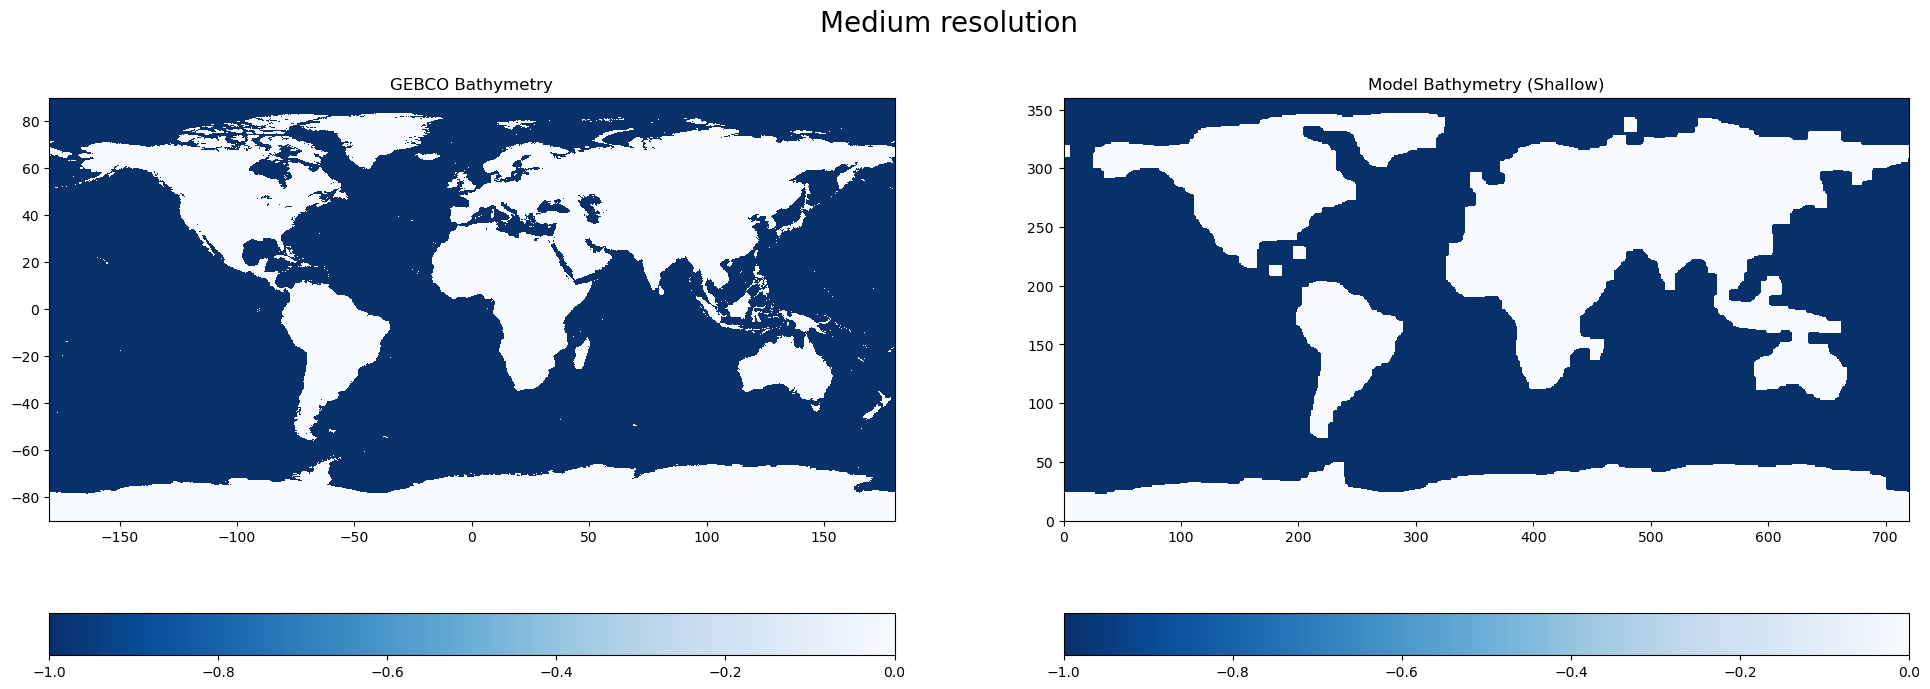

In [33]:
def vis_final_comp(Globe_Lon, Globe_Lat, Globe_bathy, Model_bathy_cleaned, res):

    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    C = plt.pcolormesh(Globe_Lon, Globe_Lat, Globe_bathy, vmin=-1, vmax=0, cmap='Blues_r')
    plt.colorbar(C, orientation = 'horizontal')
    plt.title('GEBCO Bathymetry')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.subplot(1,2,2)
    C = plt.pcolormesh(Model_bathy_cleaned, vmin=-1, cmap='Blues_r')
    plt.title('Model Bathymetry (Shallow)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(C, orientation='horizontal')

    plt.suptitle(res + ' resolution', fontsize=20)

    plt.show()

vis_final_comp(Globe_Lon, Globe_Lat, Globe_bathy, clean_grid_coarse, 'Coarse')
vis_final_comp(Globe_Lon, Globe_Lat, Globe_bathy, clean_grid_medium, 'Medium')

In [ ]:
def save_bathys(Model_bathy_cleaned, output_file):
    Model_bathy_cleaned.ravel('C').astype('>f4').tofile(output_file)

course_file = 'demo_global_bathymetry_cor_deg.bin'
medium_file = 'demo_global_bathymetry_med_deg.bin'
save_bathys(clean_grid_coarse, course_file)
save_bathys(clean_grid_medium, medium_file)

This will be implemented into the model by renaming each bathy file and editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'global_bathymetry.bin,
 &
```